# EDA (SUBSET 1/4)

In [3]:
import pandas as pd

### Data preparation

The netflix data is split into 4 files: combined_data_X.txt

The data is formatted as such:

movie_id_1: \
user1, rating, date\
user2, rating, date\
...

movie_id_2:\
user1, rating, date\
user2, rating, date\
...

movie_id_X:\
userX, rating, date\
userY rating, date\
...

From this raw data, we turn this into a flat Pandas Dataframe, with each row being one observation (1 rating).

In [4]:
df_raw = pd.read_parquet("data/combined_ratings_500.parquet")

In [5]:
df = df_raw.drop('unique_index', axis=1)

df['date'] = pd.to_datetime(df['date'])

In [6]:
# small subset of 500 movies
df.describe()

,user_id,rating,date,movie_id
count,2.798704e+06,2.798704e+06,2798704,2.798704e+06
mean,1.322497e+06,3.623953e+00,2004-10-21 03:16:05.473161472,2.806436e+02
min,6.000000e+00,1.000000e+00,1999-12-09 00:00:00,1.000000e+00
25%,6.609950e+05,3.000000e+00,2004-05-24 00:00:00,1.870000e+02
50%,1.319503e+06,4.000000e+00,2005-01-12 00:00:00,2.990000e+02
75%,1.984315e+06,4.000000e+00,2005-06-30 00:00:00,3.930000e+02
max,2.649429e+06,5.000000e+00,2005-12-31 00:00:00,5.000000e+02
std,7.645609e+05,1.078990e+00,NaN,1.371310e+02


In [7]:
df.head()

,user_id,rating,date,movie_id
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1


In [8]:
user_counts = df['user_id'].value_counts()


# We can see through this that ~370000 unique users provided a rating
print("Number of users rated:", len(user_counts))

Number of users rated: 370169


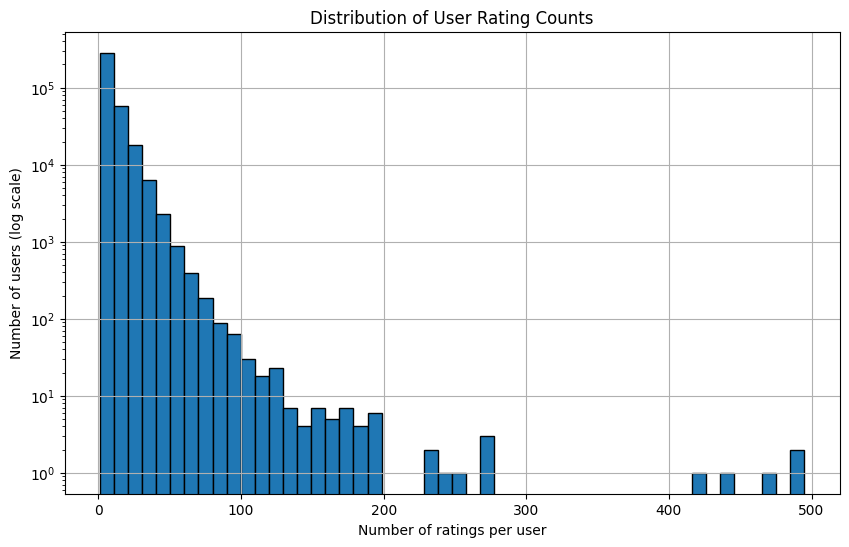

In [9]:
import matplotlib.pyplot as plt

user_counts = df['user_id'].value_counts()

plt.figure(figsize=(10, 6))
plt.hist(user_counts, bins=50, edgecolor='black', log=True)
plt.xlabel("Number of ratings per user")
plt.ylabel("Number of users (log scale)")
plt.title("Distribution of User Rating Counts")
plt.grid(True)
plt.show()

We see that most users tend to not give too many ratings, even though this is only a subset of the data, we can expect the rest of the data to be similarly sparse. We'll account for this sparsity in our training.

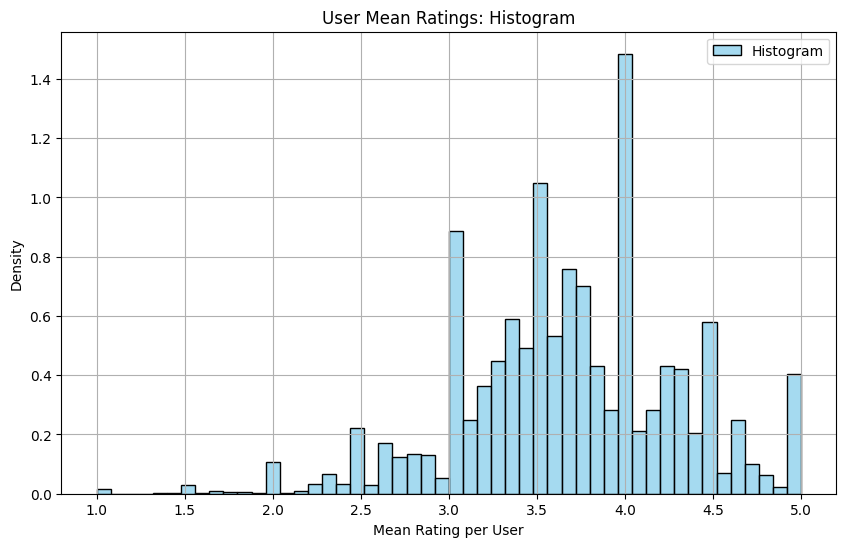

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

user_stats = df.groupby('user_id')['rating'].agg(['mean', 'std'])
user_stats = user_stats.dropna()  # drop users with only one rating (std = NaN)

plt.figure(figsize=(10, 6))

# Histogram (density-scaled)
sns.histplot(user_stats['mean'], bins=50, stat="density", color='skyblue', edgecolor='black', kde=False, label='Histogram')

plt.xlabel("Mean Rating per User")
plt.ylabel("Density")
plt.title("User Mean Ratings: Histogram")
plt.legend()
plt.grid(True)
plt.show()

This histogram shows that on average, users tend to rate movies positively (rating > 2.5). 

Moreover there are spikes on the multiples of .5, with the highest spike being 4.0. These show that a lot of users don't show a lot of variation in their rating. Users that tend to give ~4.0 ratings seem to give ~4.0 ratings consistently.

### Sparsity: The Cold-Start Problem

We'll take a look at the sparsity of the data, i.e. how "full" our matrix of users x movies is

In [11]:
### Sparsity
n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()
n_ratings = len(df)

total_possible = n_users * n_movies
sparsity = 1 - (n_ratings / total_possible)

print(f"Users: {n_users}")
print(f"Movies: {n_movies}")
print(f"Actual ratings: {n_ratings}")
print(f"Matrix size: {total_possible}")
print(f"Sparsity: {sparsity:.4%}")

Users: 370169
Movies: 500
Actual ratings: 2798704
Matrix size: 185084500
Sparsity: 98.4879%


We obtain a value of ~98.5% sparsity which is expected for recommender data. Many movies are niche, meaning they don't get rated as often, many users don't rate all the movies they watch. Let's sample a part of our matrix to visualize this sparsity.

In [12]:
# top 100 sample
top_users = df['user_id'].value_counts().head(100).index
top_movies = df['movie_id'].value_counts().head(100).index

sample_df = df[df['user_id'].isin(top_users) & df['movie_id'].isin(top_movies)]

matrix = sample_df.pivot(index='user_id', columns='movie_id', values='rating').notnull().astype(int)

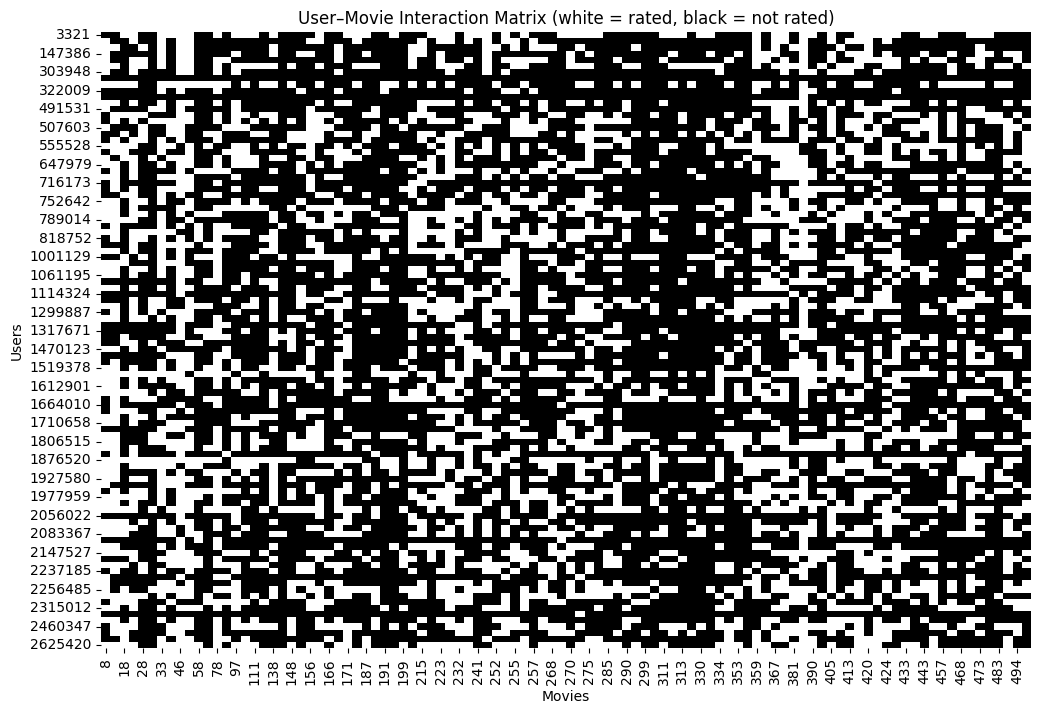

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, cmap='Greys', cbar=False)
plt.title("User–Movie Interaction Matrix (white = rated, black = not rated)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()

This level of sparsity is one of the main challenges of recommender system. When so little data is available, algorithms struggle to extract any pattern from the data: this is known as the "cold-start problem." 

The problem usually occurs when there's a new platform, and users have not yet have time to give us enough data for training. As collaborative filtering relies heavily on past behavior, we look at a few solutions:

1. <b>Content-based filtering:</b> Recommend based on user or item features (e.g., genre, age, location) instead of past ratings
2. <b>Hybrid models:</b> Combine collaborative + content-based recommendations
3. <b>Onboarding questionnaires:</b> Ask new users to rate a few items or select preferences
4. <b>Popular item fallback:</b> Recommend trending or universally liked items initially
5. <b>Cold-start-aware learning:</b> Use side information (e.g., metadata, text, embeddings) in neural models or GNNs